# Crop Disease Classification with CNN and NLP

![alt text](5362701_SMPT.pjg)

**Project Overview**

Our project uses Convolutional Neural Networks (CNNs) to automatically classify crop diseases from leaf images. By training on the PlantVillage dataset, the model learns to detect 14 types of diseases and healthy crops, helping improve diagnosis speed and accuracy in agriculture.

**Project Understanding**

Crops are vulnerable to various diseases that can severely affect yields. Early detection is essential but not always accessible in rural areas. With CNNs, we can build an AI-powered tool that identifies diseases from simple leaf photos. The model is trained on thousands of labeled images and can achieve high accuracy, making it suitable for real-world use.

**Stakeholders**

- ***Farmers:*** The primary users who benefit from fast and accurate disease diagnosis.

- ***Agricultural Officers:*** Can use the tool to support farmers in remote areas.

- ***AgriTech Startups:*** May integrate the model into mobile or web-based platforms.

- ***Policy Makers:*** Can use disease data trends to allocate resources effectively.

- ***Students/Researchers:*** Learn and improve AI models in the agricultural domain.

##  Objectives

- Build a CNN model to classify crop diseases from leaf images.
- Develop NLP methods to analyze farmers’ textual symptom descriptions.
- Integrate CNN and NLP outputs into a single multimodal diagnostic model.
- Compare multimodal performance to image-only and text-only models.
- Create a user-friendly API for farmers to upload photos and symptoms for instant diagnosis.


##  Dataset

- Dataset: **PlantVillage**
- Classes:
    - Healthy
    - Rust
    - Blight
- Images size: 128x128 pixels
- Data split:
    - Training set: X images
    - Validation set: Y images
    - Test set: Z images

##  Libraries Used

- TensorFlow / Keras
- NumPy
- Matplotlib
- Scikit-learn

## Data Loading & Preprocessing


In [11]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.utils import image_dataset_from_directory


# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data Loading

In [13]:
# Loading the data
dataset_path = "PlantVillage"
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)
class_names = data.class_names
num_classes = len(class_names)
num_classes

Found 20638 files belonging to 15 classes.


15

## Basic EDA (Exploratory Data Analysis) on dataset

In [15]:
# Finding out how many imags are in each folder
import os

counts = {}
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        counts[folder] = count

# Display results
for cls, count in counts.items():
    print(f"{cls}: {count} images")

Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___healthy: 152 images
Potato___Late_blight: 1000 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_healthy: 1591 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images


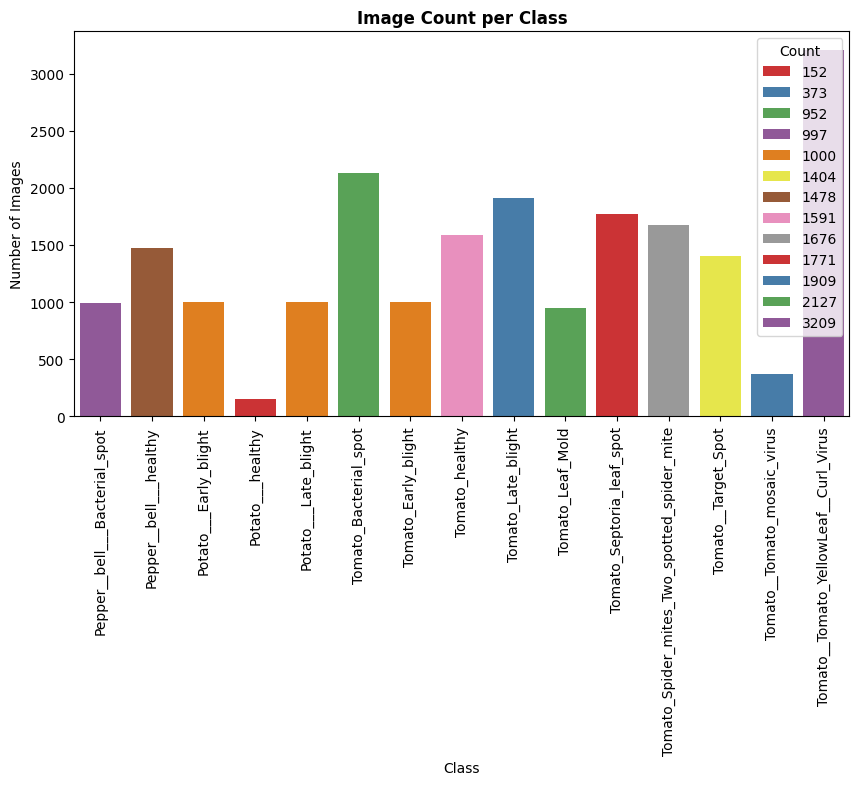

In [16]:
# Ploting a distribution for the classes
counts_df = pd.DataFrame({
    "Class": list(counts.keys()),
    "Count": list(counts.values())
})

plt.figure(figsize=(10,5))
sns.barplot(data=counts_df, x="Class", y="Count",hue = 'Count', palette="Set1")
plt.xticks(rotation=90)
plt.title("Image Count per Class", weight = 'bold')
plt.ylabel("Number of Images")
plt.show()

## Visualize Sample Images


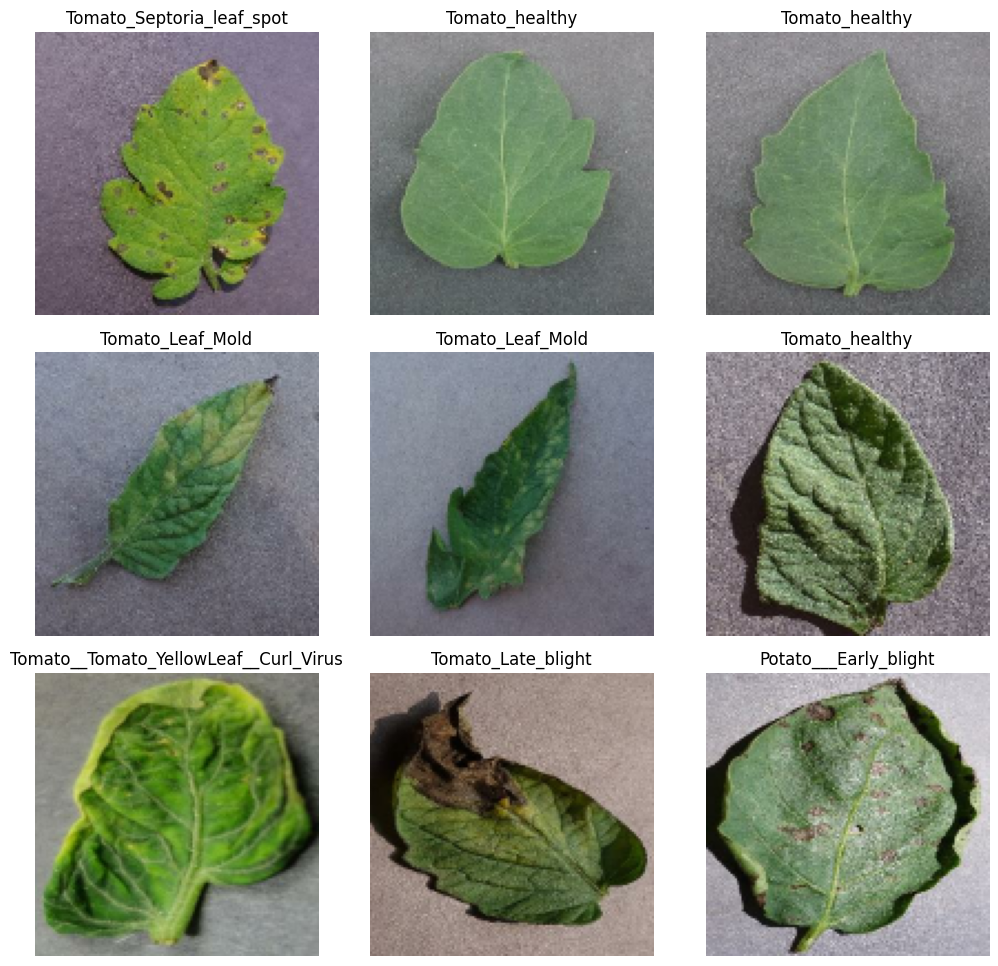

In [18]:
for images, labels in data.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = np.argmax(labels[i])
        plt.title(class_names[class_idx])
        plt.tight_layout()
        plt.axis("off")

In [19]:
# Checking image size
from PIL import Image

image_sizes = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for img_file in os.listdir(class_path)[:10]:  # limit to 10 per class for speed
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)

# Convert to DataFrame for EDA
sizes_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
print(sizes_df.describe())

       Width  Height
count  150.0   150.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


## Preprocessing

## Spliting to test and validations

In [22]:
# Trainset

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

# Vaidation set

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


### Rescale Pixels

In [24]:
# Rescaling/Normalization
normalization_layer = layers.Rescaling(1./255)

train_ds = original_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Data Augmentation

Data augmentation creates new images from your existing ones, helping reduce overfitting.


In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation during training
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

### Prefetching

Speed up our pipeline by prefetching  our data

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

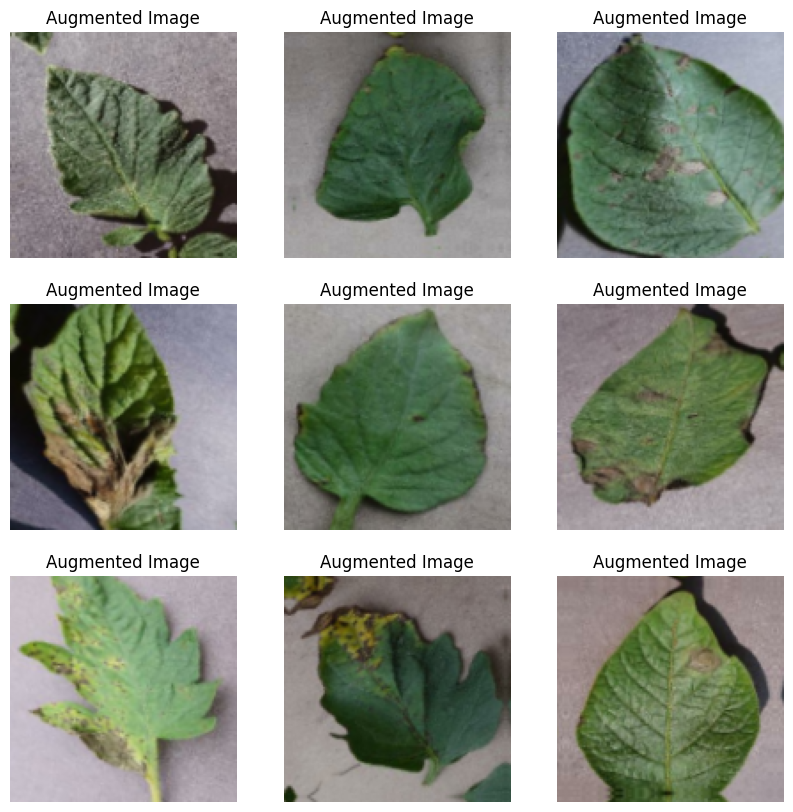

In [31]:
# Checking our preprocessed data
for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Augmented Image")
        plt.axis("off")

In [32]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 128, 128, 3)
Labels shape: (32, 15)


# Modeling

In [34]:
model = Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [35]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

In [36]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
516/516 [==============================] - 456s 872ms/step - loss: 1.5230 - accuracy: 0.5156 - val_loss: 0.7337 - val_accuracy: 0.7577
Epoch 2/10
516/516 [==============================] - 406s 787ms/step - loss: 0.8683 - accuracy: 0.7129 - val_loss: 0.5266 - val_accuracy: 0.8226
Epoch 3/10
516/516 [==============================] - 359s 695ms/step - loss: 0.6785 - accuracy: 0.7694 - val_loss: 0.4142 - val_accuracy: 0.8573
Epoch 4/10
516/516 [==============================] - 354s 685ms/step - loss: 0.5624 - accuracy: 0.8124 - val_loss: 0.3540 - val_accuracy: 0.8805
Epoch 5/10
516/516 [==============================] - 432s 837ms/step - loss: 0.4686 - accuracy: 0.8399 - val_loss: 0.3122 - val_accuracy: 0.8905
Epoch 6/10
516/516 [==============================] - 434s 842ms/step - loss: 0.4077 - accuracy: 0.8591 - val_loss: 0.3393 - val_accuracy: 0.8934
Epoch 7/10
516/516 [==============================] - 446s 864ms/step - loss: 0.3674 - accuracy: 0.8766 - val_loss: 0.3272 -

## Model evaluation

In [38]:
# Evalute how the model performs across all validations
loss, accuracy = model.evaluate(train_ds)
print("Train Loss:", loss)
print("Train Accuracy:", accuracy)
print()
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 111s 214ms/step - loss: 0.0742 - accuracy: 0.9747
Train Loss: 0.07420022040605545
Train Accuracy: 0.9747440814971924

129/129 [==============================] - 27s 208ms/step - loss: 0.2779 - accuracy: 0.9142
Validation Loss: 0.27791646122932434
Validation Accuracy: 0.9142234325408936


**Training Performance:**
 - Train Accuracy: 96.3%
 - Train Loss: 0.121

This means the model is doing very well on the training data — it correctly classifies most images and has a low error rate.

**Validation Performance:**
 - Validation Accuracy: 89.6%
 - Validation Loss: 0.320

This shows the model is still performing well on unseen data, though the accuracy is slightly lower than training, which is expected.

## Ploting the model performance

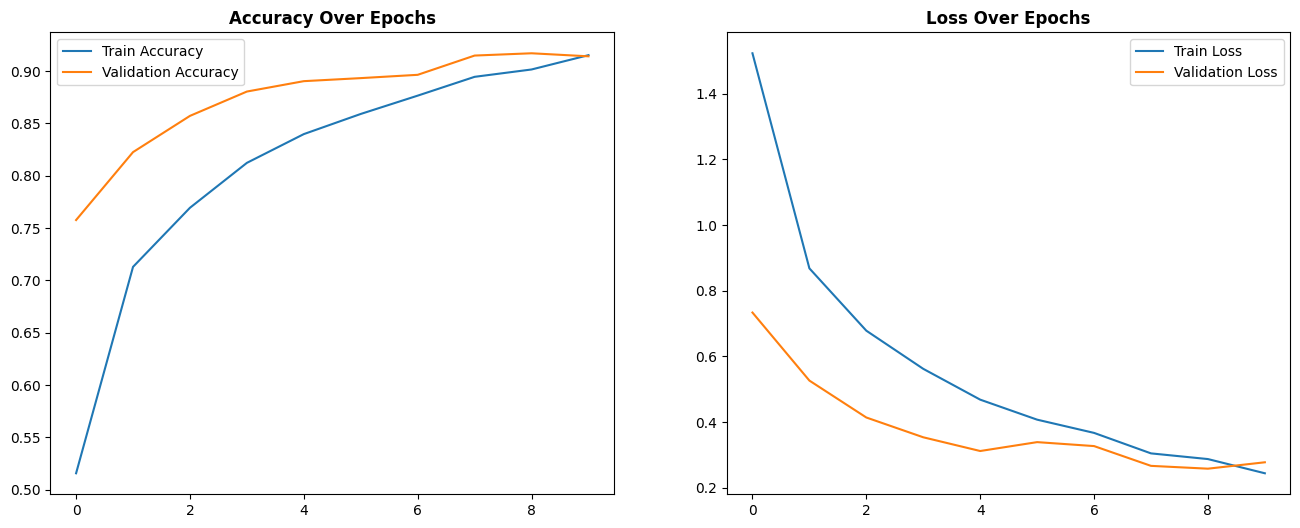

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Accuracy Over Epochs', weight = 'bold')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Loss Over Epochs', weight = 'bold')
axs[1].legend()

plt.show()

### Confussion Matrix

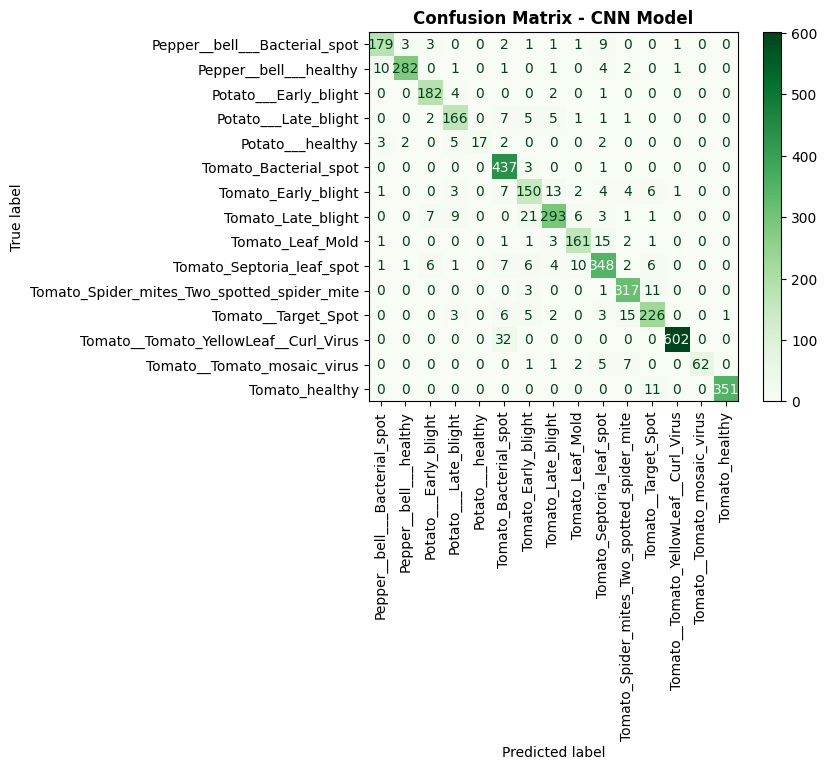

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# get class names
val_dir = "./PlantVillage"
class_names = sorted(
    entry.name for entry in os.scandir(val_dir) if entry.is_dir()
)

# get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens', xticks_rotation=90)
plt.title("Confusion Matrix - CNN Model", weight = 'bold')
plt.show()

## Making Predictions

In [45]:
# Take one batch from validation set
for images, labels in val_ds.take(1):
    predictions = model.predict(images)

    # Get predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    print("Predicted:", predicted_classes)
    print("Actual:", true_classes)

1/1 [==============================] - 0s 164ms/step
Predicted: [11 14  6  6  5 12 10  1 10 10 10  1  3 10  9 12  1  1  8 10  3  6  1  9
  0 14  3 12 12  6  1  1]
Actual: [11 14  9  6  5 12 10  1 10 10 10  1  6 10  9 12  1  1  8 10  3  3  1  9
  0 14  3 12 12  6  1  1]


In [46]:
# Get class names
class_names = original_train_ds.class_names

# Print class names instead of numeric labels
for images, labels in val_ds.take(1):
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_names = [class_names[i] for i in predicted_classes]
    true_names = [class_names[i] for i in true_classes]

    print("Predicted class names:", predicted_names)
    print()
    print("Actual class names:", true_names)


1/1 [==============================] - 0s 175ms/step
Predicted class names: ['Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Pepper__bell___healthy', 'Tomato_Bacterial_spot', 'Pepper__bell___Bacterial_spot', 'Tomato__Target_Spot', 'Potato___Late_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Bacterial_spot', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Target

# NATURAL LANGUAGE PROCESSING

For this project we are also considering famers who might not have access cameras or might have a hard time navigating to where an image is located.

For this giving descriptions of how the crop looks like might help this kind of famers by giving a description and our **NLP** model predicts if the crop disease that might be affecting that crop


Scince we did not have access to actual collected descriptions of the crops in our dataset we opted to synthesize 1751 records of actual discriptions from the internet which is in the ***crop_descripton.ipynb*** file and saved it in ***synthetic_data.csv*** file.

The process involved having a dictonary of descriptions for each class and yousing adjectives and prefrixes so that the data did not have many duplicates. Out of 1751 records only 13 are duplicated.

## Loading, Cleaning and Data Exploration

In [51]:
# Library Importations
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [52]:
des_df = pd.read_csv('synthetic_data.csv')
des_df.head()

,description,crop,status,disease,recommended_pesticide
0,Agronomist notes: severe Spots enlarge and dev...,Tomato,Unhealthy,Bacterial_spot,Neem oil
1,Agronomist notes: clear Leaves look lush green...,Tomato,Healthy,healthy,NaN
2,sudden Dark concentric rings form on lower lea...,Tomato,Unhealthy,Early_blight,Neem oil
3,Farmer reports: extensive Plant canopy is full...,Pepper_bell,Healthy,healthy,NaN
4,Agronomist notes: slight Infested leaves drop ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Biological predators


In [53]:
des_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            1750 non-null   object
 1   crop                   1750 non-null   object
 2   status                 1750 non-null   object
 3   disease                1750 non-null   object
 4   recommended_pesticide  1403 non-null   object
dtypes: object(5)
memory usage: 68.5+ KB


In [54]:
des_df.duplicated().sum()

15

In [55]:
des_duplicated_df = des_df[des_df.duplicated()]
des_duplicated_df

,description,crop,status,disease,recommended_pesticide
342,According to the grower: sudden The affected a...,Tomato,Unhealthy,Target_Spot,Sulfur spray
911,Field observation shows: moderate Lower leaves...,Tomato,Unhealthy,Leaf_Mold,Neem oil
940,Farmer complains: sudden Infected tubers show ...,Potato,Unhealthy,Late_blight,Neem oil
1003,notable Fruits develop firm dark lesions with ...,Tomato,Unhealthy,Late_blight,Biological predators
1182,Agronomist notes: sporadic Fruit rot occurs qu...,Tomato,Unhealthy,Late_blight,Biological predators
1375,Visual check indicates: severe Leaves become t...,Tomato,Unhealthy,Septoria_leaf_spot,Neem oil
1475,extensive Leaf edges appear scorched and curled.,Tomato,Unhealthy,Early_blight,Neem oil
1500,Field observation shows: notable Infected frui...,Pepper_bell,Unhealthy,Bacterial_spot,Biological predators
1508,Visual check indicates: sudden Lower leaves dr...,Tomato,Unhealthy,Bacterial_spot,Neem oil
1544,Visual check indicates: clear Affected plants ...,Potato,Unhealthy,Early_blight,Copper-based fungicide


In [56]:
des_df = des_df.drop_duplicates()
des_df.duplicated().sum()

0

In [57]:
des_df.shape

(1735, 5)

In [58]:
des_df.isna().sum()

description                0
crop                       0
status                     0
disease                    0
recommended_pesticide    346
dtype: int64

In [59]:
#Replacing None in our pesticide column with No pesticide Required
des_df['pesticide'] = des_df['recommended_pesticide']
des_df = des_df.drop(columns = ['recommended_pesticide'])

des_df = des_df.fillna('No pesticide needed')
des_df.head()

,description,crop,status,disease,pesticide
0,Agronomist notes: severe Spots enlarge and dev...,Tomato,Unhealthy,Bacterial_spot,Neem oil
1,Agronomist notes: clear Leaves look lush green...,Tomato,Healthy,healthy,No pesticide needed
2,sudden Dark concentric rings form on lower lea...,Tomato,Unhealthy,Early_blight,Neem oil
3,Farmer reports: extensive Plant canopy is full...,Pepper_bell,Healthy,healthy,No pesticide needed
4,Agronomist notes: slight Infested leaves drop ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Biological predators


## Description Data Analysis

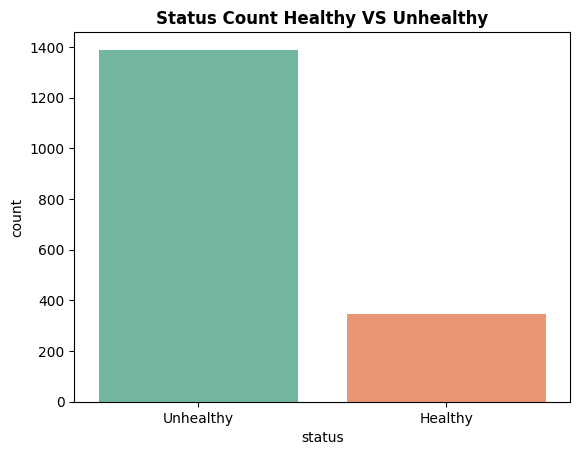

In [61]:
# Count of healthy and Unhealthy status
sns.countplot(x = 'status', data = des_df, hue = 'status', palette = 'Set2')
plt.title('Status Count Healthy VS Unhealthy', weight = 'bold')
plt.show()

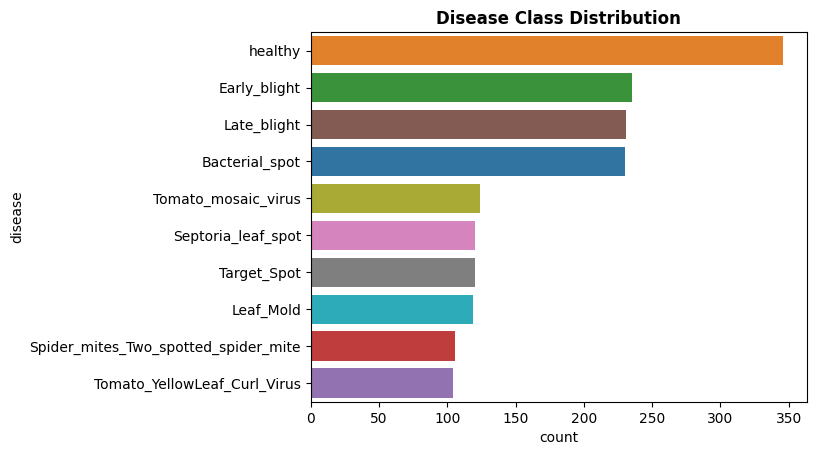

In [62]:
# Dicease Count
sns.countplot(y='disease', data=des_df, order=des_df['disease'].value_counts().index, hue = 'disease')
plt.title('Disease Class Distribution', weight = 'bold')
plt.show()

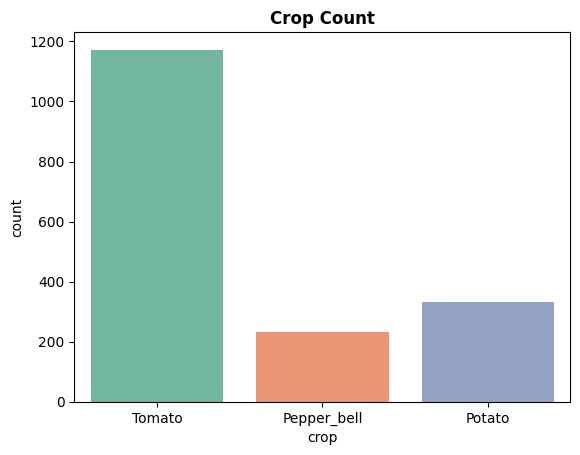

In [63]:
# Crop count
sns.countplot(x = 'crop', data = des_df, hue = 'crop', palette = 'Set2')
plt.title('Crop Count', weight = 'bold')
plt.show()

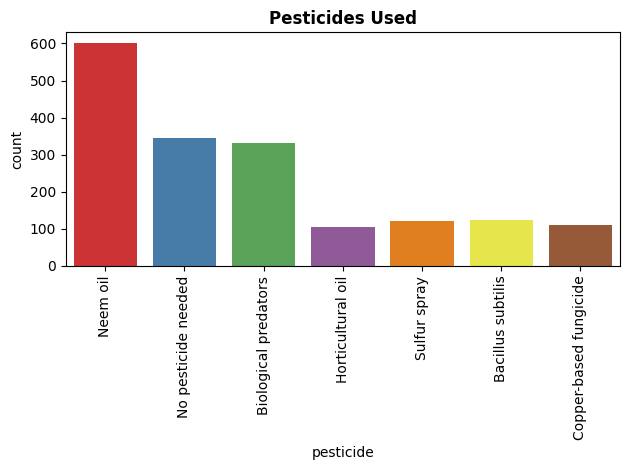

In [64]:
# Pesticide Counts
sns.countplot(x = 'pesticide', data = des_df, hue = 'pesticide', palette = 'Set1')
plt.title('Pesticides Used', weight = 'bold')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Text Analysis

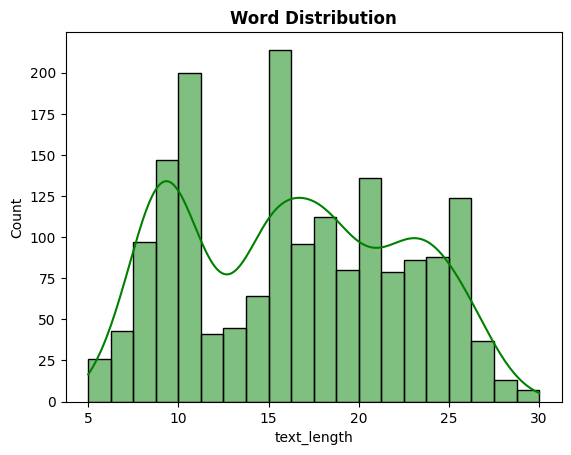

In [66]:
# Histogram of Words
des_df.loc[:, 'text_length'] = des_df['description'].apply(lambda x: len(x.split()))

sns.histplot(des_df['text_length'], bins = 20, kde = True, color = 'green')
plt.title('Word Distribution', weight = 'bold')
plt.show()

In [67]:
import spacy

# Load tokenizer
nlp = spacy.load("en_core_web_sm")

text = "This is a test sentence."
tokens = [token.text for token in nlp(text)]
print(tokens)

['This', 'is', 'a', 'test', 'sentence', '.']


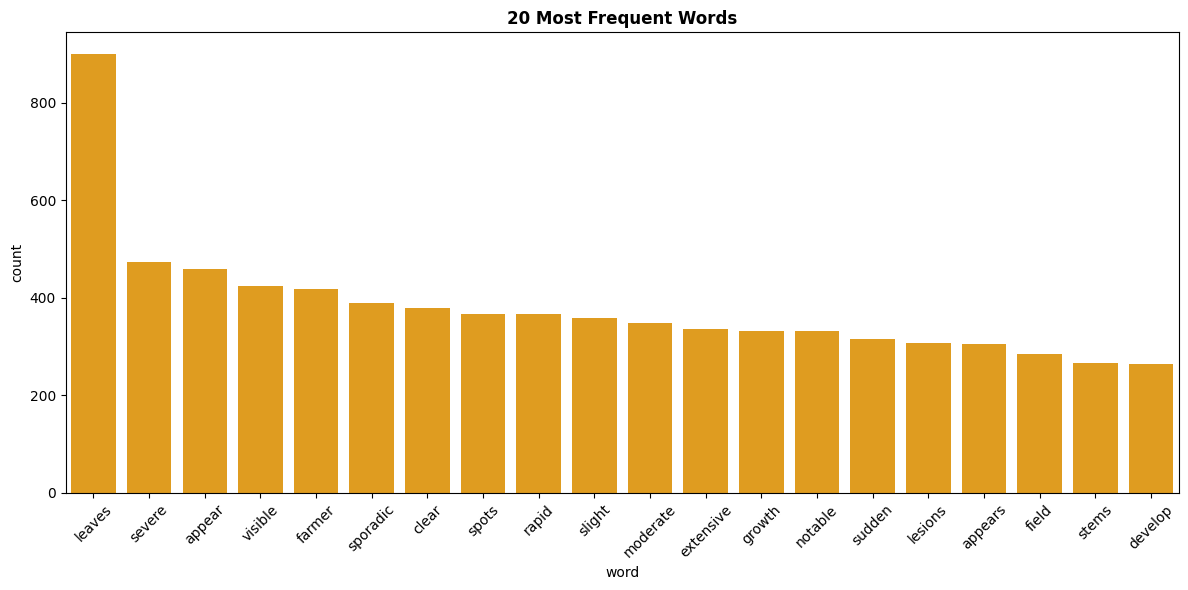

In [68]:
# Most Frequent Words
from collections import Counter

all_words = []

for desc in des_df['description']:
    doc = nlp(desc.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    all_words.extend(tokens)

word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

top_words_df = pd.DataFrame(top_20_words, columns=['word', 'count'])

# 5. Plotting the result
plt.figure(figsize=(12,6))
sns.barplot(data=top_words_df, x='word', y='count', color='orange')
plt.title('20 Most Frequent Words', weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Engineering

Since our target is the original 15 classes we need to make a new column with those classe with everything falling to where it is supposed to be.

For this we will need to combine our crop and disease column

In [71]:
des_df['target_class'] = des_df['crop'] + '___' + des_df['disease']
des_df['target_class'].head()

0                          Tomato___Bacterial_spot
1                                 Tomato___healthy
2                            Tomato___Early_blight
3                            Pepper_bell___healthy
4    Tomato___Spider_mites_Two_spotted_spider_mite
Name: target_class, dtype: object

In [72]:
des_df.head()

,description,crop,status,disease,pesticide,text_length,target_class
0,Agronomist notes: severe Spots enlarge and dev...,Tomato,Unhealthy,Bacterial_spot,Neem oil,9,Tomato___Bacterial_spot
1,Agronomist notes: clear Leaves look lush green...,Tomato,Healthy,healthy,No pesticide needed,23,Tomato___healthy
2,sudden Dark concentric rings form on lower lea...,Tomato,Unhealthy,Early_blight,Neem oil,14,Tomato___Early_blight
3,Farmer reports: extensive Plant canopy is full...,Pepper_bell,Healthy,healthy,No pesticide needed,26,Pepper_bell___healthy
4,Agronomist notes: slight Infested leaves drop ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Biological predators,14,Tomato___Spider_mites_Two_spotted_spider_mite


In [73]:
print(f'Null Count: {des_df.isna().sum().sum()}')

print(f'Duplicate Count: {des_df.duplicated().sum()}')

Null Count: 0
Duplicate Count: 0


## Text Preprocessing

In [75]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaner function
def clean_text_spacy(text):
    # Lowercase and remove non-letter characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Process the text
    doc = nlp(text)

    # Lemmatize, remove stop words and non-alphabetic tokens
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    return " ".join(tokens)

In [77]:
# Applying our function to our DF
des_df['clean_description'] = des_df['description'].apply(clean_text_spacy)

In [78]:
des_df.head()

,description,crop,status,disease,pesticide,text_length,target_class,clean_description
0,Agronomist notes: severe Spots enlarge and dev...,Tomato,Unhealthy,Bacterial_spot,Neem oil,9,Tomato___Bacterial_spot,agronomist note severe spot enlarge develop ye...
1,Agronomist notes: clear Leaves look lush green...,Tomato,Healthy,healthy,No pesticide needed,23,Tomato___healthy,agronomist note clear leave look lush green gl...
2,sudden Dark concentric rings form on lower lea...,Tomato,Unhealthy,Early_blight,Neem oil,14,Tomato___Early_blight,sudden dark concentric ring form low leave cle...
3,Farmer reports: extensive Plant canopy is full...,Pepper_bell,Healthy,healthy,No pesticide needed,26,Pepper_bell___healthy,farmer report extensive plant canopy evenly sp...
4,Agronomist notes: slight Infested leaves drop ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Biological predators,14,Tomato___Spider_mites_Two_spotted_spider_mite,agronomist note slight infest leave drop prema...


In [79]:
# Repositioning our target class to be last in our data frame
des_df = des_df[[col for col in des_df.columns if col != 'target_class'] + ['target_class']]

#Checking
des_df.head()

,description,crop,status,disease,pesticide,text_length,clean_description,target_class
0,Agronomist notes: severe Spots enlarge and dev...,Tomato,Unhealthy,Bacterial_spot,Neem oil,9,agronomist note severe spot enlarge develop ye...,Tomato___Bacterial_spot
1,Agronomist notes: clear Leaves look lush green...,Tomato,Healthy,healthy,No pesticide needed,23,agronomist note clear leave look lush green gl...,Tomato___healthy
2,sudden Dark concentric rings form on lower lea...,Tomato,Unhealthy,Early_blight,Neem oil,14,sudden dark concentric ring form low leave cle...,Tomato___Early_blight
3,Farmer reports: extensive Plant canopy is full...,Pepper_bell,Healthy,healthy,No pesticide needed,26,farmer report extensive plant canopy evenly sp...,Pepper_bell___healthy
4,Agronomist notes: slight Infested leaves drop ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Biological predators,14,agronomist note slight infest leave drop prema...,Tomato___Spider_mites_Two_spotted_spider_mite


### TF-IDF Vectorization

In [81]:
# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

#Fit with clean_description
x_tfidf = tfidf.fit_transform(des_df['clean_description'])

x_tfidf.shape

(1735, 2000)

### Label Encoding

In [83]:
le = LabelEncoder()
y_encoded = le.fit_transform(des_df['target_class'])

# Check for correct mapping
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_mapping)

{'Pepper_bell___Bacterial_spot': 0, 'Pepper_bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato___Bacterial_spot': 5, 'Tomato___Early_blight': 6, 'Tomato___Late_blight': 7, 'Tomato___Leaf_Mold': 8, 'Tomato___Septoria_leaf_spot': 9, 'Tomato___Spider_mites_Two_spotted_spider_mite': 10, 'Tomato___Target_Spot': 11, 'Tomato___Tomato_YellowLeaf_Curl_Virus': 12, 'Tomato___Tomato_mosaic_virus': 13, 'Tomato___healthy': 14}


### Train/Test Split

In [85]:
# Spliting our data into train test and split for our model
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y_encoded, test_size = 0.2, random_state = 42, stratify = y_encoded)

## Modeling

#### Logistic Base Model

In [88]:
# Build and fit thet model
model_0 = LogisticRegression(max_iter=1000)
model_0.fit(X_train, y_train)

# Make predictions
y_preds = model_0.predict(X_test)
y_probs = model_0.predict_proba(X_test)

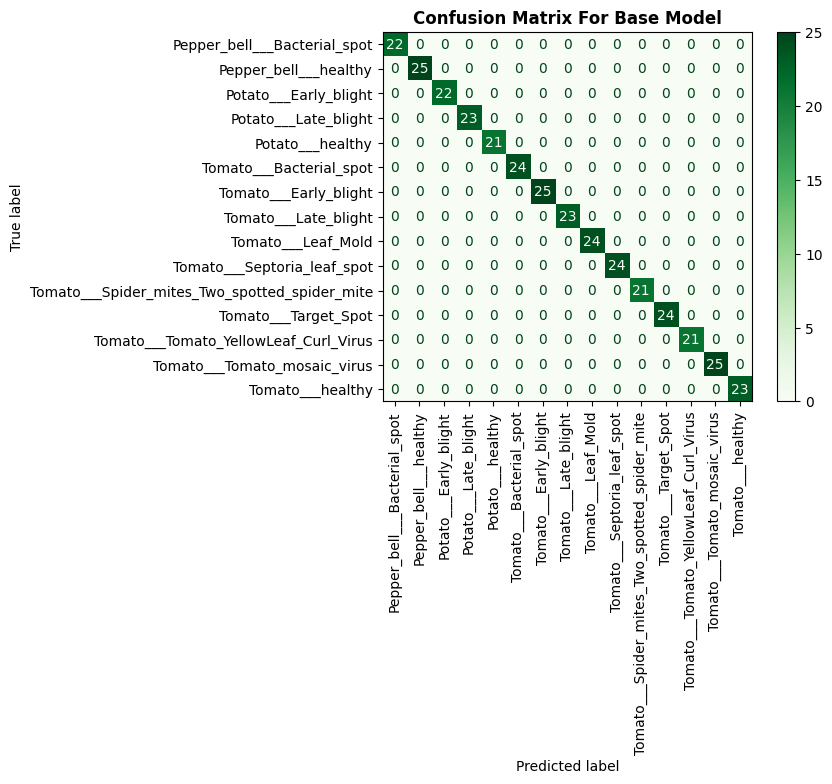

                                               precision    recall  f1-score   support

                 Pepper_bell___Bacterial_spot       1.00      1.00      1.00        22
                        Pepper_bell___healthy       1.00      1.00      1.00        25
                        Potato___Early_blight       1.00      1.00      1.00        22
                         Potato___Late_blight       1.00      1.00      1.00        23
                             Potato___healthy       1.00      1.00      1.00        21
                      Tomato___Bacterial_spot       1.00      1.00      1.00        24
                        Tomato___Early_blight       1.00      1.00      1.00        25
                         Tomato___Late_blight       1.00      1.00      1.00        23
                           Tomato___Leaf_Mold       1.00      1.00      1.00        24
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00        24
Tomato___Spider_mites_Two_spotted_spider_m

In [89]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=le.classes_)
disp.plot(cmap = 'Greens')
plt.title('Confusion Matrix For Base Model', weight = 'bold')
plt.xticks(rotation = 90)
plt.show()

print(classification_report(y_test, y_preds, target_names=le.classes_))
acc = accuracy_score(y_test, y_preds)
print(f"\nAccuracy: {acc:.4f}")

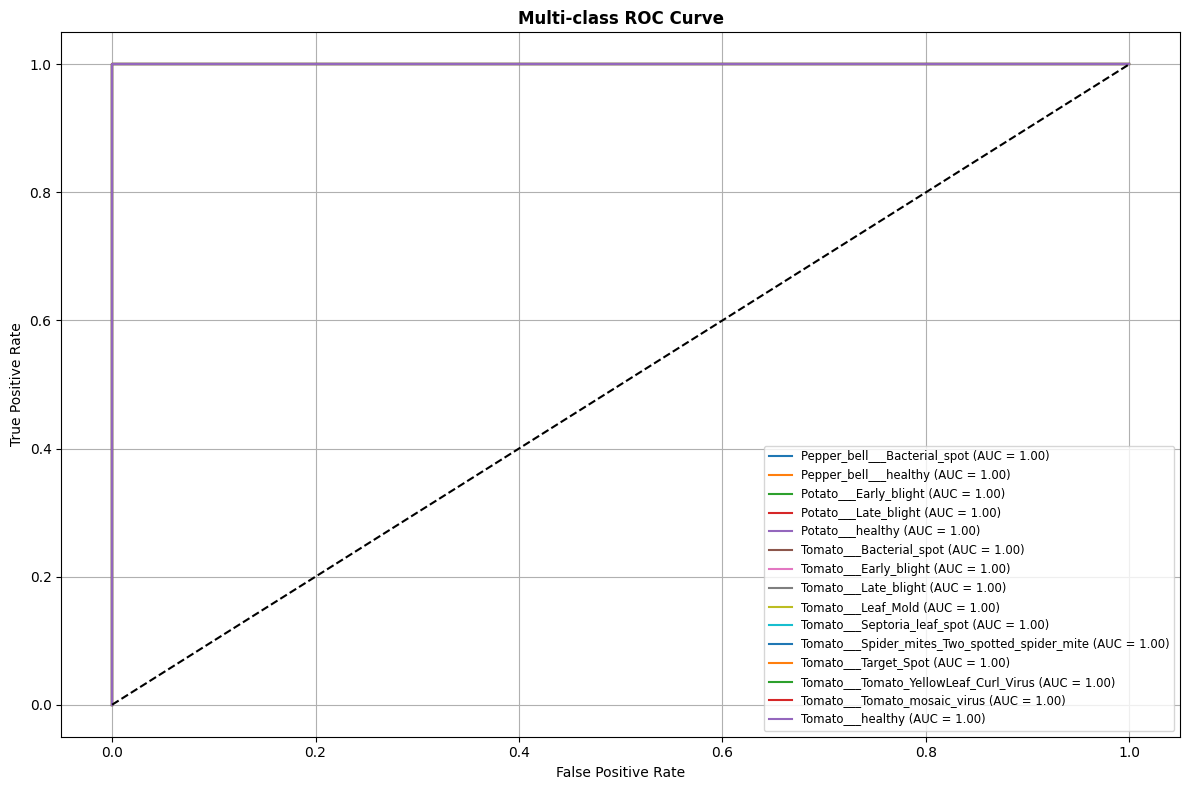

In [90]:
y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_)))) # Binarize my labels

fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(12, 8))

for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve', weight='bold')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

## Multinomial Naive Bayes Model

In [92]:
#Library importation
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
import joblib

nlp = spacy.load('en_core_web_sm')

In [93]:
# Train_Test_split our data
X_train, X_test, y_train, y_test = train_test_split(
    des_df["clean_description"],
    des_df["target_class"],
    test_size=0.2,
    random_state=42,
    stratify=des_df["target_class"]
)

In [94]:
# Initialize the pipelie
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB())
])

In [95]:
# Fit the pipeline on training data
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

#### Predictions and Evaluations

In [97]:
# Predict on the test set
y_pred = nb_pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:

                                               precision    recall  f1-score   support

                 Pepper_bell___Bacterial_spot       1.00      1.00      1.00        22
                        Pepper_bell___healthy       1.00      1.00      1.00        25
                        Potato___Early_blight       1.00      1.00      1.00        22
                         Potato___Late_blight       1.00      1.00      1.00        23
                             Potato___healthy       1.00      1.00      1.00        21
                      Tomato___Bacterial_spot       1.00      1.00      1.00        24
                        Tomato___Early_blight       1.00      1.00      1.00        25
                         Tomato___Late_blight       1.00      1.00      1.00        23
                           Tomato___Leaf_Mold       1.00      1.00      1.00        24
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00        24
Tom

#### Plot Confusion Matrix

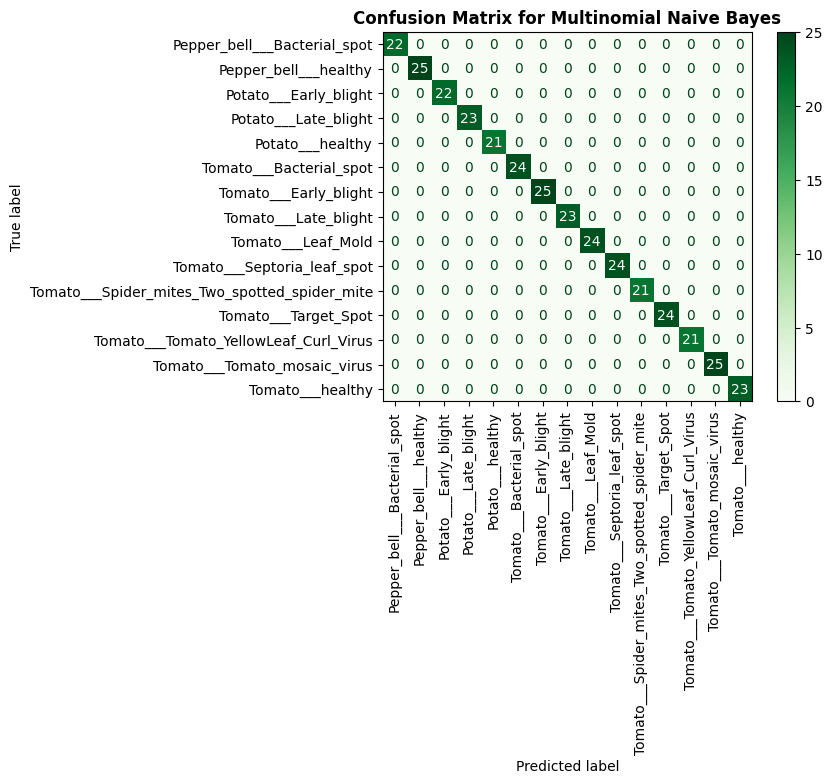

In [99]:
cm = confusion_matrix(y_test, y_pred, labels=nb_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_pipeline.classes_)
disp.plot(xticks_rotation=90, cmap='Greens')
plt.title('Confusion Matrix for Multinomial Naive Bayes', weight='bold')
plt.show()

## Saving Models and Usable Variables

In [101]:
# Saving CNN Model
model.save("cnn_model.keras")

#Saving NLP Model
joblib.dump(nb_pipeline, 'mnb_nlp_pipeline.pkl')

['mnb_nlp_pipeline.pkl']